In [1]:
# @title <p> Import Dependencies
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, MaxPool2D, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
import os
import pickle
import cv2
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report,accuracy_score,f1_score,confusion_matrix


In [2]:
# @title <p> Import Data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_dir = '/content/drive/MyDrive/lettuce_experimental-20240529T190721Z-001/lettuce_experimental'
train_path = os.path.join(root_dir, 'train')
valid_path = os.path.join(root_dir, 'valid')
test_path = os.path.join(root_dir, 'test')

Label : Fungal
Shape : (183, 276, 3)


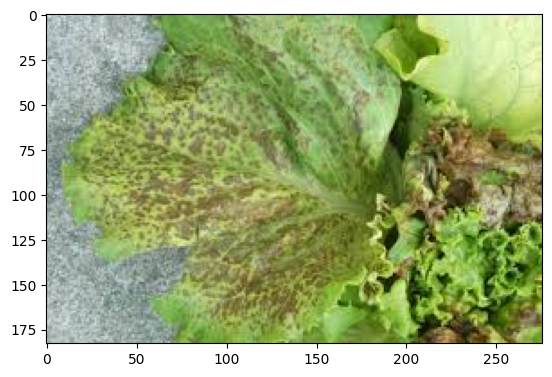

In [4]:
# @title <p> Read images
for label in os.listdir(train_path):
  for img in os.listdir(os.path.join(train_path, label)):
    img = plt.imread(os.path.join(train_path, label, img))
    break
  break

print(f'Label : {label}\nShape : {img.shape}' )
plt.imshow(img)

In [5]:
# @title <p> Menyiapkan ImageDataGenerator untuk augmentasi data dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=300,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Memuat data dari folder
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

test_generator = valid_test_datagen.flow_from_directory(
    test_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 87 images belonging to 4 classes.
Found 122 images belonging to 4 classes.


In [6]:
# @title <p> Model Building
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(256, 256, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(512, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1024),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(4, activation='softmax')
])



model.compile(optimizer=Adam(learning_rate=1e-4, decay = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# @title <p> Model Training
r = model.fit(train_generator,
              steps_per_epoch=len(train_generator),
              epochs=80,
              validation_data= valid_generator,
              validation_steps = len(valid_generator))

Epoch 1/80
65/65 [==============================] - 677s 10s/step - loss: 1.2133 - accuracy: 0.5217 - val_loss: 2.0196 - val_accuracy: 0.2874
Epoch 2/80
65/65 [==============================] - 69s 1s/step - loss: 0.9140 - accuracy: 0.6525 - val_loss: 2.4221 - val_accuracy: 0.2874
Epoch 3/80
65/65 [==============================] - 69s 1s/step - loss: 0.8085 - accuracy: 0.6945 - val_loss: 2.1709 - val_accuracy: 0.2874
Epoch 4/80
65/65 [==============================] - 69s 1s/step - loss: 0.7427 - accuracy: 0.7179 - val_loss: 1.4352 - val_accuracy: 0.3448
Epoch 5/80
65/65 [==============================] - 70s 1s/step - loss: 0.6561 - accuracy: 0.7511 - val_loss: 1.2643 - val_accuracy: 0.5057
Epoch 6/80
65/65 [==============================] - 69s 1s/step - loss: 0.6756 - accuracy: 0.7369 - val_loss: 0.9390 - val_accuracy: 0.5632
Epoch 7/80
65/65 [==============================] - 69s 1s/step - loss: 0.6190 - accuracy: 0.7555 - val_loss: 0.6545 - val_accuracy: 0.7356
Epoch 8/80
65/65 [

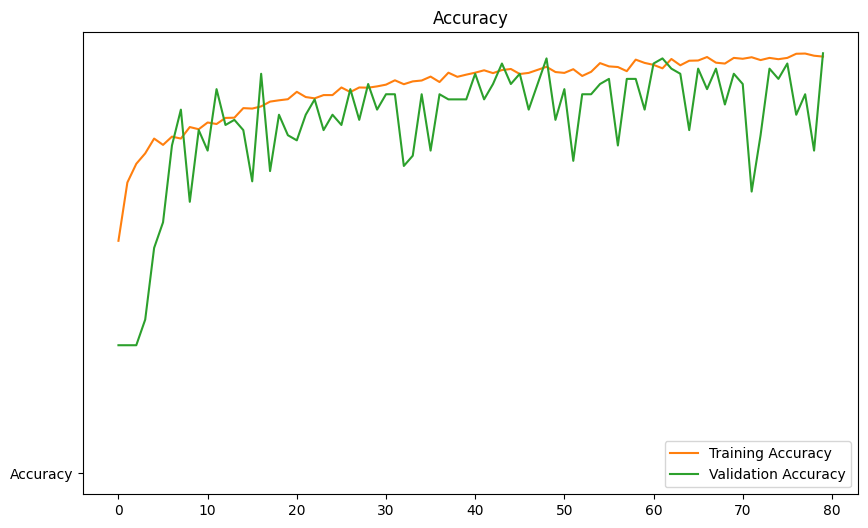

In [8]:
# @title <p> Plot Training dan valid accuracy
plt.figure(figsize=(10, 6))
plt.title("Accuracy")
plt.plot('Accuracy')
plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

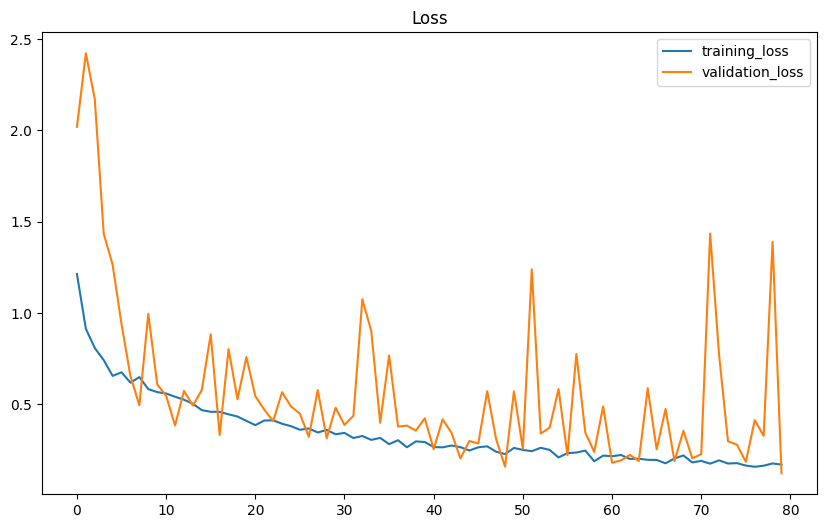

In [9]:
# @title <p> Plot Training dan valid loss
plt.figure(figsize=(10, 6))
plt.title('Loss')
plt.plot(r.history['loss'], label='training_loss')
plt.plot(r.history['val_loss'], label='validation_loss')
plt.legend()

In [10]:
# @title <p> Menyimpan Model

# Menyimpan model ke file
model.save('/content/drive/MyDrive/lettuce_experimental/saved_model/my_model.h5')

# Memuat model dari file
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/lettuce_experimental/saved_model/my_model.h5')

# Membuat plot arsitektur model
plot_model(loaded_model, to_file='/content/drive/MyDrive/lettuce_experimental/saved_model/model_architecture.png', show_shapes=True, show_layer_names=True)

print("Model and architecture plot saved successfully.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model and architecture plot saved successfully.


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256, 256, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 128)     5

In [12]:
# Mengkonversi model ke TFLite dengan mengaktifkan fallback TF Select Ops
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Menggunakan ops bawaan TFLite
    tf.lite.OpsSet.SELECT_TF_OPS     # Mengaktifkan ops TensorFlow Select
]

tflite_model = converter.convert()

# Menyimpan model TFLite ke file
tflite_model_path = '/content/drive/MyDrive/lettuce_experimental/saved_model/my_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("Model converted to TFLite with TensorFlow Select Ops and saved successfully.")


Model converted to TFLite with TensorFlow Select Ops and saved successfully.


<ipython-input-13-a6d652fcc3de>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator,steps=number_of_samples)


              precision    recall  f1-score   support

   Bacterial       0.94      0.94      0.94        32
   Deficient       1.00      1.00      1.00        30
      Fungal       1.00      0.88      0.94        25
     Healthy       0.92      1.00      0.96        35

    accuracy                           0.96       122
   macro avg       0.96      0.95      0.96       122
weighted avg       0.96      0.96      0.96       122



<Axes: >

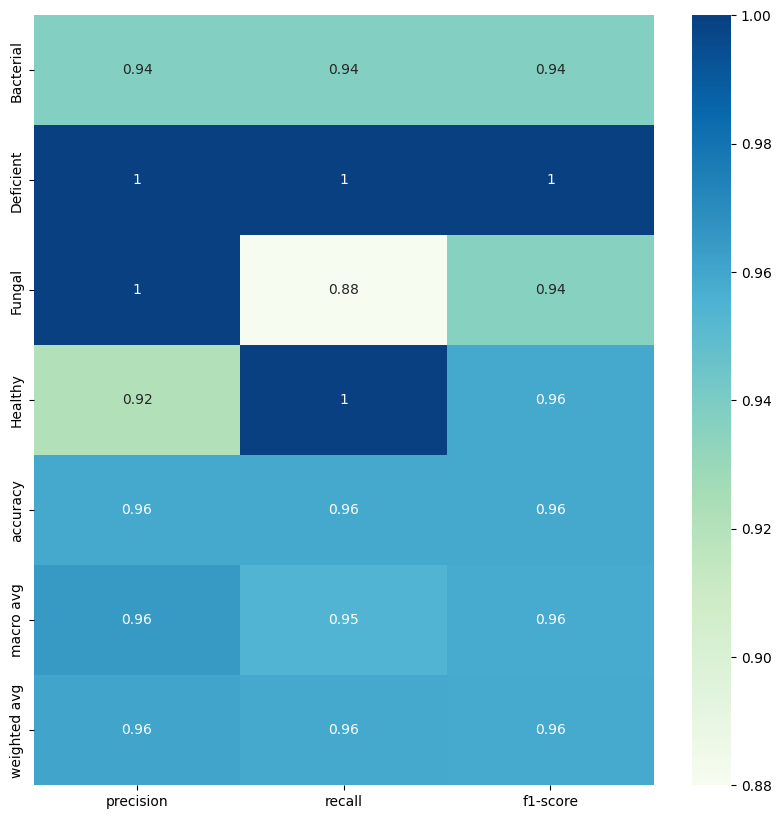

In [13]:
# @title <p> Classification Report
filename = test_generator.filenames
number_of_samples = len(filename)
y_pred = model.predict_generator(test_generator,steps=number_of_samples)
y_pred = np.argmax(y_pred, axis=1)

#getting true label

y_true = np.array([])

for img_url in filename:
  if "Bacterial" in img_url:
    y_true = np.append(y_true,0)
  elif "Deficient" in img_url:
    y_true = np.append(y_true,1)
  elif "Fungal" in img_url:
    y_true = np.append(y_true,2)
  elif "Healthy" in img_url:
    y_true = np.append(y_true,3)

diseases_title = ["Bacterial","Deficient","Fungal","Healthy"]

#Classification Report

print(classification_report(y_true, y_pred, target_names=diseases_title))
clr = classification_report(y_true, y_pred,output_dict=True, target_names=diseases_title)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pd.DataFrame(clr).iloc[:-1, :].T, annot=True,cmap = "GnBu")

In [14]:
#Test set accuracy
accuracy_score(y_true,y_pred)

0.9590163934426229

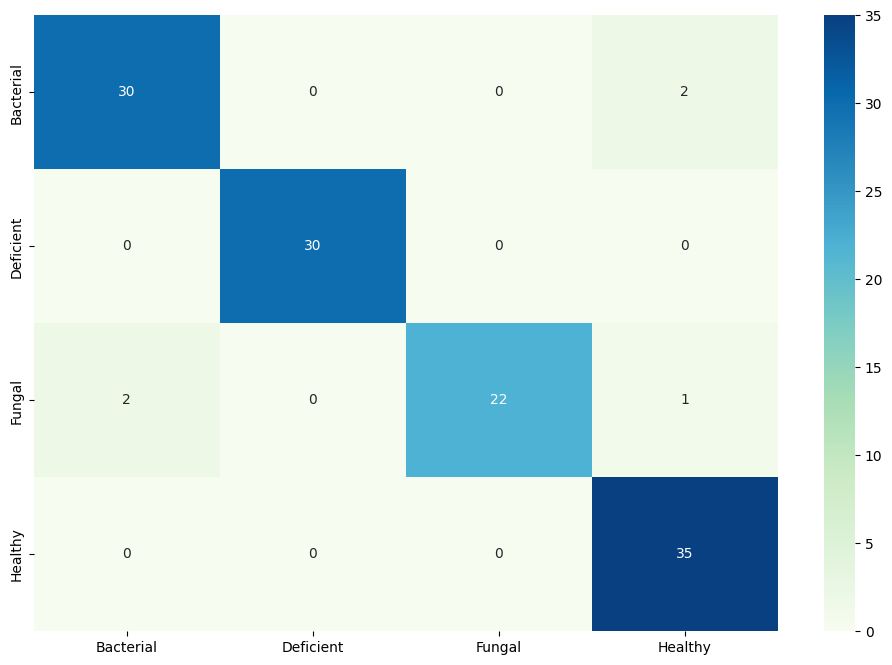

In [15]:
#Plotting Confusion Matrix
plt.figure(figsize=[12,8])
sns.heatmap(confusion_matrix(y_true,y_pred),annot = True, fmt = "d", cmap = "GnBu",xticklabels=diseases_title,yticklabels=diseases_title);

In [16]:
# @title <p> Menyimpan model tanpa optimizer
# Simpan model tanpa optimizer
# model.save('/content/drive/MyDrive/lettuce_experimental/saved_model/my_model_no_optimizer.h5', include_optimizer=False)

# Muat kembali model tanpa optimizer
# model_no_optimizer = tf.keras.models.load_model('/content/drive/MyDrive/lettuce_experimental/saved_model/my_model_no_optimizer.h5')

# Mengkonversi model ke TFLite dengan mengaktifkan fallback TF Select Ops
# converter = tf.lite.TFLiteConverter.from_keras_model(model_no_optimizer)
# converter.target_spec.supported_ops = [
    # tf.lite.OpsSet.TFLITE_BUILTINS,  # Menggunakan ops bawaan TFLite
    # tf.lite.OpsSet.SELECT_TF_OPS     # Mengaktifkan ops TensorFlow Select
# ]

# tflite_model = converter.convert()

# Menyimpan model TFLite ke file
# tflite_model_path = '/content/drive/MyDrive/lettuce_experimental/saved_model/my_model.tflite'
# with open(tflite_model_path, 'wb') as f:
    # f.write(tflite_model)

# print("Model converted to TFLite with TensorFlow Select Ops and saved successfully.")
